# AMLB shorter runs visualizations 

In [1]:
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import Orange

from visualization_early import FRAMEWORK_TO_COLOR
from data_processing import get_print_friendly_name, impute_missing_results, calculate_ranks, is_old

In [2]:
PROJECT_ROOT = Path(".").absolute().parent
DATA_DIRECTORY = PROJECT_ROOT / "data"
FIGURE_DIRECTORY = PROJECT_ROOT / "figures" / "CD"
FIGURE_DIRECTORY.mkdir(parents=True, exist_ok=True)

In [3]:
results = pd.read_csv(DATA_DIRECTORY / "amlb_all.csv", dtype={"info": str})
results["framework"] = results["framework"].apply(get_print_friendly_name)

In [4]:
results.framework.unique()

array(['AutoGluon(HQIL)_10min', 'AutoGluon(HQIL)_30min',
       'AutoGluon(HQIL)_5min', 'AutoGluon(HQIL)_60min',
       'AutoGluon(HQ)_10min', 'AutoGluon(HQ)_30min', 'AutoGluon(HQ)_5min',
       'AutoGluon(HQ)_60min', 'AutoGluon(B)_10min', 'AutoGluon(B)_30min',
       'AutoGluon(B)_5min', 'AutoGluon(B)_60min', 'FEDOT_10min',
       'FEDOT_30min', 'FEDOT_5min', 'FEDOT_60min', 'GAMA(B)_10min',
       'GAMA(B)_30min', 'GAMA(B)_5min', 'GAMA(B)_60min',
       'H2OAutoML_10min', 'H2OAutoML_30min', 'H2OAutoML_5min',
       'H2OAutoML_60min', 'NaiveAutoML_10min', 'NaiveAutoML_30min',
       'NaiveAutoML_5min', 'NaiveAutoML_60min', 'RF_60min', 'TPOT_10min',
       'TPOT_30min', 'TPOT_5min', 'TPOT_60min', 'TRF_60min',
       'autosklearn2_10min', 'autosklearn2_30min', 'autosklearn2_5min',
       'autosklearn2_60min', 'autosklearn_10min', 'autosklearn_30min',
       'autosklearn_5min', 'autosklearn_60min', 'CP_60min', 'flaml_10min',
       'flaml_30min', 'flaml_5min', 'flaml_60min', 'lightautoml_

In [5]:
from IPython.display import display

with pd.option_context("display.max_rows", None):
    display(results.groupby(by=["constraint", "framework"]).size())

constraint              framework            
Mixed Time Constraints  AutoGluon(B)_10min       1040
                        AutoGluon(B)_30min       1040
                        AutoGluon(B)_5min        1040
                        AutoGluon(B)_60min       1040
                        AutoGluon(HQ)_10min      1040
                        AutoGluon(HQ)_30min      1040
                        AutoGluon(HQ)_5min       1040
                        AutoGluon(HQ)_60min      1040
                        AutoGluon(HQIL)_10min    1040
                        AutoGluon(HQIL)_30min    1040
                        AutoGluon(HQIL)_5min     1040
                        AutoGluon(HQIL)_60min    1040
                        CP_60min                 1040
                        FEDOT_10min              1040
                        FEDOT_30min              1040
                        FEDOT_5min               1040
                        FEDOT_60min              1040
                        GAMA(B)_10mi

# Distributon plot

In [6]:
name_mapping = {
    'constantpredictor_60min': 'CP_60min',
    'RandomForest_60min': 'RF_60min',
    'TunedRandomForest_60min': 'TRF_60min'
}

In [7]:
strings_by_time = ['_5min', '_10min', '_30min', '_60min']
extra_frameworks = ['RF_60min', 'TRF_60min', 'CP_60min']

### Correlation among frameworks

In [8]:
total_dictionary = dict()
for name_time in strings_by_time:
    print("This is the time constraint", name_time)
    for task in results.task.unique():
        this_dataframe = results[results['framework'].str.contains(name_time) | results['framework'].isin(extra_frameworks)]
        this_dataframe = this_dataframe.loc[this_dataframe['task'] == task]
        this_dataframe['framework'] = this_dataframe['framework'].apply(lambda x: name_mapping.get(x, x))
        data = this_dataframe.copy()
        data = impute_missing_results(data, with_results_from="CP_60min")
        data['framework'] = data['framework'].apply(lambda x: x.replace(name_time, ''))
        data['framework'] = data['framework'].apply(lambda x: x.replace("_60min", ''))
        data = data[data['framework'] != 'CP']
        ranks = calculate_ranks(data)
        total_dictionary[(name_time.replace("_",""), task)] = ranks
   

This is the time constraint _5min
This is the time constraint _10min
This is the time constraint _30min
This is the time constraint _60min


### Correlation(task, constraint_1, constraint_2)

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Extract Data
data_dict = {}
for (time, task), ranks in total_dictionary.items():
    if time not in data_dict:
        data_dict[time] = {}
    data_dict[time][task] = ranks

# Step 2: Calculate Correlations
correlation_data = []
time_pairs = [('5min', '60min'), ('10min', '60min'), ('30min', '60min')]
for time1, time2 in time_pairs:
    tasks = set(data_dict[time1].keys()).intersection(data_dict[time2].keys())
    for task in tasks:
        ranks_time1 = pd.Series(data_dict[time1][task])
        ranks_time2 = pd.Series(data_dict[time2][task])
        correlation = ranks_time1.corr(ranks_time2)
        correlation_data.append({'Time1': time1, 'Time2': time2, 'Task': task, 'Correlation': correlation})

# Step 3: Prepare DataFrame
correlation_df = pd.DataFrame(correlation_data)


### Correlation based on features

In [10]:
import openml
from openml.tasks import OpenMLRegressionTask

In [12]:
def dataset_imbalanced(dataset_qualities, threshold=1.5):
    """
    Determine if the dataset is imbalanced based on the given threshold.
    
    Parameters:
    - dataset_qualities (dict): Dictionary containing dataset qualities.
    - threshold (float): Threshold for determining imbalance. Default is 1.5.
    
    Returns:
    - bool: True if the dataset is imbalanced, False otherwise.
    """
    majority_class_percentage = dataset_qualities.get('MajorityClassPercentage')
    minority_class_percentage = dataset_qualities.get('MinorityClassPercentage')
    
    if majority_class_percentage is None or minority_class_percentage is None:
        raise ValueError("MajorityClassPercentage or MinorityClassPercentage is missing in dataset qualities.")

    # Calculate the imbalance ratio
    imbalance_ratio = float(minority_class_percentage / majority_class_percentage)
    
    # Determine if the dataset is imbalanced
    return round(imbalance_ratio, 2)
    

In [13]:
ids_string = results.id.unique()
# ids = [element.replace("openml.org/t/", "") for element in ids_string]
list_binary = []
list_multiclass = []
list_regression = []
percentage_numeric_feature = []
imbalance_dataset = []
balance_dataset = []
dataset_ids = dict()
dataset_ids_instances = dict()
dataset_ids_features = dict()
dataset_n_classes = dict()
dataset_ratio = dict()
for task_id in results.id.unique():
    name_task = results[results['id']==task_id].task.unique()[0]
    task_id = task_id.replace("openml.org/t/", "")
    task = openml.tasks.get_task(task_id)
    # if task.PercentageOfNumericFeatures >50:
    #    percentage_numeric_feature.append(name_task)
    dataset_id = task.dataset_id
    dataset = openml.datasets.get_dataset(dataset_id, download_data = False)
    dataset_ids[name_task] = dataset_id
    dataset_ids_instances[name_task] = dataset.qualities['NumberOfInstances']
    dataset_ids_features[name_task] = dataset.qualities['NumberOfFeatures']
    if isinstance(task, OpenMLRegressionTask):
        list_regression.append(name_task)
        dataset_n_classes[name_task] = float('nan')
        dataset_ratio[name_task] = float('nan')
    else:
        dataset_n_classes[name_task] = len(task.class_labels)
        dataset_ratio[name_task] = dataset_imbalanced(dataset.qualities)
        if len(task.class_labels) == 2:
            list_binary.append(name_task)
        else:
            list_multiclass.append(name_task)

C:\Users\20210595\.conda\envs\visualize_5\lib\site-packages\IPython\core\interactiveshell.py:3550: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\20210595\.conda\envs\visualize_5\lib\site-packages\IPython\core\interactiveshell.py:3550: FutureWarning: Task id must be specified as `int` from 0.14.0 onwards.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\20210595\.conda\envs\visualize_5\lib\site-packages\openml\tasks\functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `downlo

In [14]:
# Define a function to assign size based on Correlation
def assign_size(correlation):
    if correlation > 0.9:
        return 10
    elif 0.9 >= correlation > 0.6:
        return 50
    else:
        return 200


In [15]:
correlation_df['size'] = correlation_df['Correlation'].apply(assign_size)
correlation_df['Features'] = correlation_df['Task'].map(dataset_ids_features)
correlation_df['Instances'] = correlation_df['Task'].map(dataset_ids_instances)
correlation_df['Ratio'] = correlation_df['Task'].map(dataset_ratio)
correlation_df['Classes'] = correlation_df['Task'].map(dataset_n_classes)
correlation_df

,Time1,Time2,Task,Correlation,size,Features,Instances,Ratio,Classes
0,5min,60min,house_prices_nominal,0.660963,50,80.0,1460.0,NaN,NaN
1,5min,60min,numerai28_6,0.885714,50,22.0,96320.0,0.98,2.0
2,5min,60min,connect-4,0.796429,50,43.0,67557.0,0.15,3.0
3,5min,60min,jungle_chess_2pcs_raw_endgame_complete,0.542857,200,7.0,44819.0,0.19,3.0
4,5min,60min,credit-g,0.754245,50,21.0,1000.0,0.43,2.0
...,...,...,...,...,...,...,...,...,...
307,30min,60min,wine-quality-white,0.975000,10,12.0,4898.0,0.00,7.0
308,30min,60min,Airlines_DepDelay_10M,0.994210,10,10.0,10000000.0,NaN,NaN
309,30min,60min,house_sales,0.942815,10,22.0,21613.0,NaN,NaN
310,30min,60min,adult,0.921429,10,15.0,48842.0,0.31,2.0


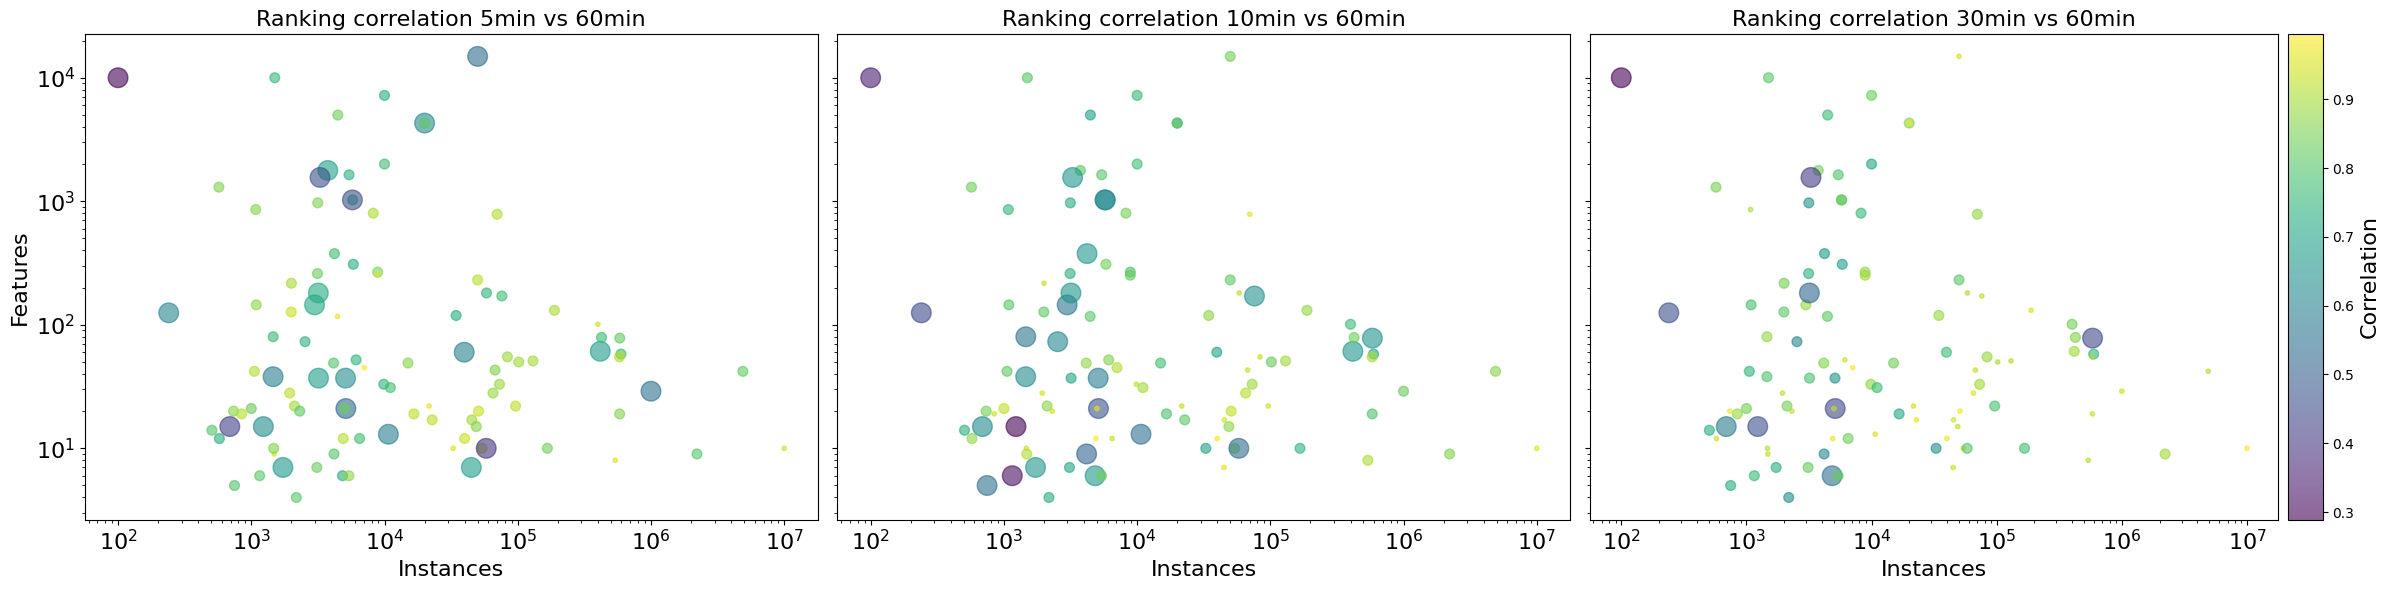

In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)

# Create a scatter plot for each time value
for i, time in enumerate(['5min', '10min', '30min']):
    this_dataframe = correlation_df[correlation_df['Time1'] == time]
    
    # Create the scatter plot
    scatter = axes[i].scatter(
        this_dataframe['Instances'],
        this_dataframe['Features'],
        s=this_dataframe['size'],  # Use the size column
        alpha=0.6,  # Set the transparency of the dots
        c=this_dataframe['Correlation'],  # Color by correlation
        cmap='viridis'
    )
    
    # Set plot labels and title
    axes[i].set_xlabel('Instances', fontsize=16)
    axes[i].set_ylabel('Features' if i == 0 else '', fontsize=16)
    axes[i].set_title(f'Ranking correlation {time} vs 60min', fontsize=16)
    axes[i].tick_params(axis='both', which='major', labelsize=16)
    
    # Set logarithmic scale for both axes
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')

# Create a new axis for the color bar
divider = make_axes_locatable(axes[-1])
cax = divider.append_axes("right", size="5%", pad=0.1)

# Add a single color bar and move it further to the right
cbar = fig.colorbar(scatter, cax=cax, orientation='vertical')
cbar.set_label('Correlation', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.savefig(FIGURE_DIRECTORY / 'ranking_correlation_features_instances.png', bbox_inches='tight', dpi=300)
plt.show()

In [17]:
datasets_struggle = correlation_df[correlation_df['Correlation']<=0.6]

In [18]:
# datasets_struggle.sort_values(by="Correlation")
set_5min = set(datasets_struggle[datasets_struggle['Time1']=='5min']['Task'])
set_10min = set(datasets_struggle[datasets_struggle['Time1']=='10min']['Task'])
set_30min = set(datasets_struggle[datasets_struggle['Time1']=='30min']['Task'])

In [19]:
# Find the intersection of the three sets
overlapping_tasks = set_5min & set_10min & set_30min

# Display the overlapping tasks
print("Tasks that overlap in all three sets:", overlapping_tasks)

Tasks that overlap in all three sets: {'Internet-Advertisements', 'arcene', 'tecator', 'Australian', 'sylvine', 'Moneyball', 'dna'}


In [20]:
filtered_correlation_df_again = correlation_df[correlation_df['Task'].isin(overlapping_tasks)]
filtered_correlation_df_again

,Time1,Time2,Task,Correlation,size,Features,Instances,Ratio,Classes
33,5min,60min,sylvine,0.317857,200,21.0,5124.0,1.00,2.0
47,5min,60min,Australian,0.182143,200,15.0,690.0,0.80,2.0
66,5min,60min,Internet-Advertisements,0.239286,200,1559.0,3279.0,0.16,2.0
82,5min,60min,dna,0.596429,200,181.0,3186.0,0.46,3.0
87,5min,60min,Moneyball,0.469749,200,15.0,1232.0,NaN,NaN
89,5min,60min,tecator,0.450549,200,125.0,240.0,NaN,NaN
93,5min,60min,arcene,-0.003571,200,10001.0,100.0,0.79,2.0
137,10min,60min,sylvine,0.339286,200,21.0,5124.0,1.00,2.0
151,10min,60min,Australian,0.535714,200,15.0,690.0,0.80,2.0
170,10min,60min,Internet-Advertisements,0.578571,200,1559.0,3279.0,0.16,2.0


In [20]:
# data.groupby(["task","framework"]).mean() Pieter idea

#### General correlation

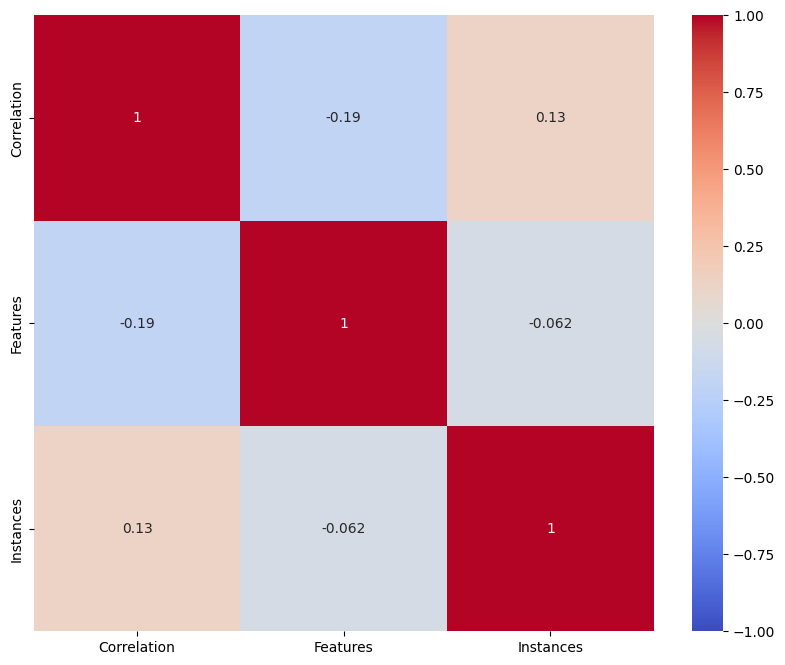

In [21]:
# Select the columns of interest
columns_of_interest = ['Correlation', 'Features', 'Instances']

# Compute the correlation matrix
correlation_matrix = correlation_df[columns_of_interest].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [22]:
correlation_matrix

,Correlation,Features,Instances
Correlation,1.000000,-0.188886,0.129864
Features,-0.188886,1.000000,-0.062026
Instances,0.129864,-0.062026,1.000000


### regression

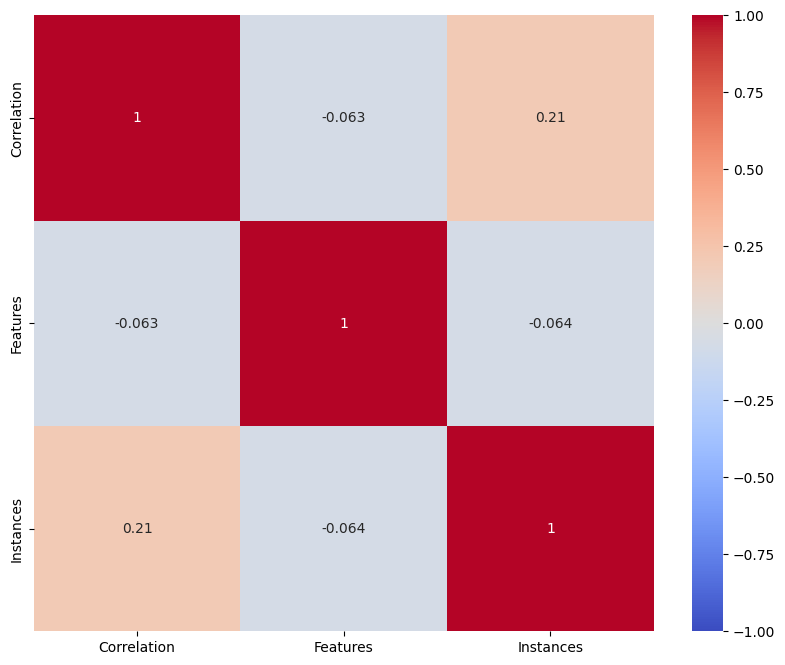

In [23]:
# Filter the DataFrame
regression_dataframe = correlation_df[correlation_df['Task'].isin(list_regression)]

# Select the columns of interest
columns_of_interest = ['Correlation', 'Features', 'Instances']

# Compute the correlation matrix
correlation_matrix = regression_dataframe[columns_of_interest].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.savefig(FIGURE_DIRECTORY / 'correlation_ranking_regression.png', bbox_inches='tight', dpi=300)
plt.show()

In [24]:
correlation_matrix

,Correlation,Features,Instances
Correlation,1.000000,-0.062560,0.210072
Features,-0.062560,1.000000,-0.063789
Instances,0.210072,-0.063789,1.000000


#### Classification

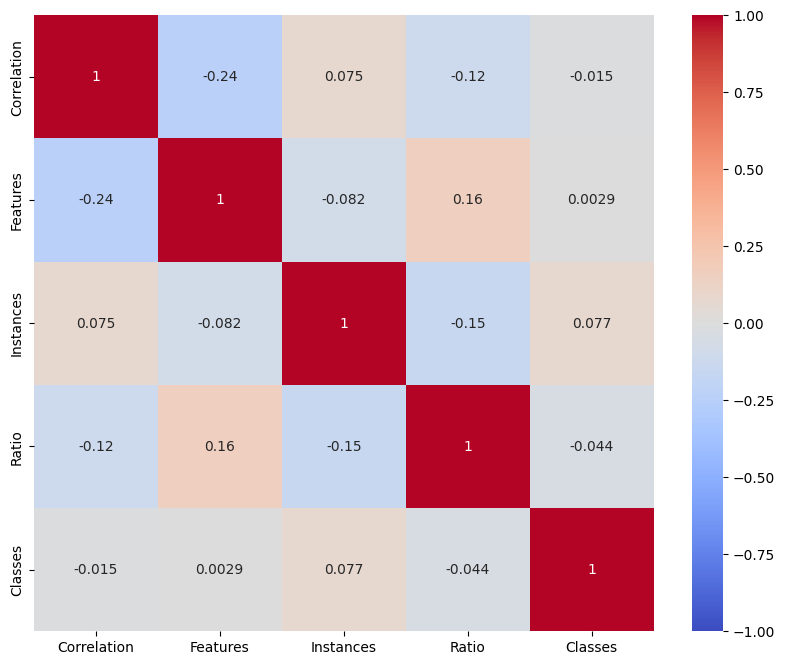

In [25]:
# Filter the DataFrame
classification_dataframe = correlation_df[correlation_df['Task'].isin(list_multiclass + list_binary)]

# Select the columns of interest
columns_of_interest = ['Correlation', 'Features', 'Instances', 'Ratio', 'Classes']

# Compute the correlation matrix
correlation_matrix = classification_dataframe[columns_of_interest].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.savefig(FIGURE_DIRECTORY / 'correlation_ranking_classification.png', bbox_inches='tight', dpi=300)
plt.show()

In [26]:
correlation_matrix

,Correlation,Features,Instances,Ratio,Classes
Correlation,1.000000,-0.239016,0.075094,-0.115476,-0.014953
Features,-0.239016,1.000000,-0.082360,0.163322,0.002858
Instances,0.075094,-0.082360,1.000000,-0.154191,0.077220
Ratio,-0.115476,0.163322,-0.154191,1.000000,-0.044380
Classes,-0.014953,0.002858,0.077220,-0.044380,1.000000
